# Analyse du modèle sélectionné pour le projet avec les valeurs SHAP

### Importation des librairies

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from catboost import CatBoostClassifier
import catboost
from data.load_dataset import load_data
import utils.utils
import shap
import numpy as np
import pandas as pd

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


### Instancier le jeu de données

In [2]:
X, y, cat_features = load_data().get_data_X_y(data='simplify')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Instancier le modèle CatBoost

In [3]:
catboost_clf = CatBoostClassifier(cat_features=cat_features, depth=6, iterations=1000, l2_leaf_reg=3, learning_rate=0.01, one_hot_max_size=150, verbose=0, random_state=42)
catboost_clf.fit(X_train, y_train)

### Performance du modèle

In [4]:
print(f"Accuracy sur les données de test : {catboost_clf.score(X_test, y_test)*100:.3f}%")
print(f"F1 score sur les donnnées de test : {f1_score(y_test, catboost_clf.predict(X_test))*100:.3f}%")

Accuracy sur les données de test : 91.368%
F1 score sur les donnnées de test : 93.295%


Pourquoi les valeurs de feature_importance ne sont pas pareil que ceux de SHAP ?

In the article for treeSHAP it is explained how many ways to evaluate the importance of features by weight or gain (for example) fail the properties of consistency and accuracy, only SHAP respects these two properties. In particular, SHAP always calculates the importance taking into account all the possible combinations, in each of which it distributes the score equally given the prediction being studied with respect to the base value.
Another example, I tried to evaluate in the case of the KernelSHAP with a FastSSVM, from the regression to the ranking, a sort of proportionality and consistency between the feature importance for the model and the calculated SHAP values: what you notice is the feature match from regression to ranking it decreases, in this case I think it is due to the assumption of feature independence for the kernelSHAP. From the regression to the ranking the range of the weight distribution becomes wider and wider, (compared to the regression in which the weights are more regularized around zero), this probably complicates the explanation given the independence of the features.

There is a big difference between both importance measures: Permutation feature importance is based on the decrease in model performance. SHAP is based on magnitude of feature attributions. The feature importance plot is useful, but contains no information beyond the importances.

In [5]:
utils.features_importance(catboost_clf, X_train.columns, plot=False)

,Importance
Unités curriculaires 2e semestre (approuvées),32.616964
Frais de scolarité à jour,9.219709
Cours,5.913198
Unités curriculaires 1er semestre (approuvées),5.204291
Unités curriculaires 2e semestre (inscrits),4.963422
Unités curriculaires 1er semestre (inscrits),4.933328
Unités curriculaires 2e semestre (note),4.651957
Unités curriculaires 1er semestre (note),3.391165
Bourse,3.154448
Âge à l'inscription,3.092575


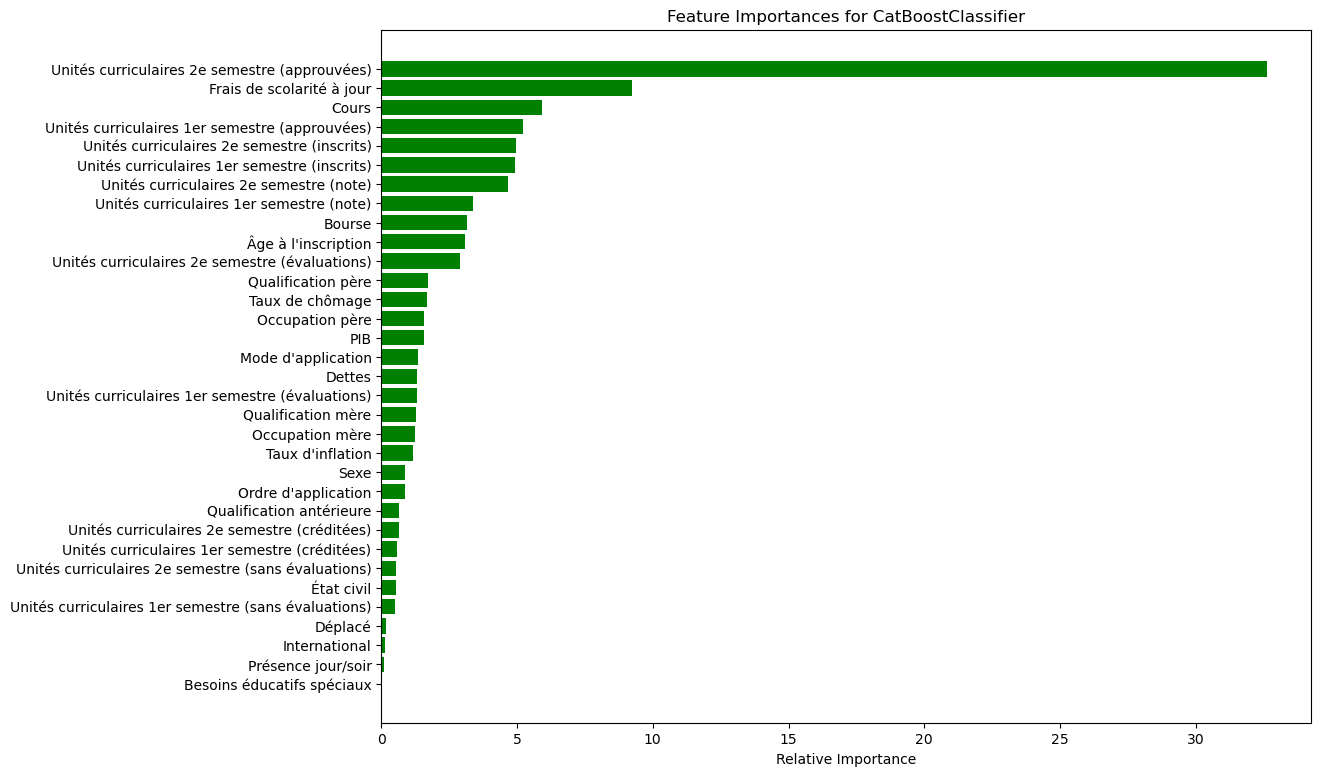

In [6]:
utils.features_importance(catboost_clf, X_train.columns, plot=True)

### Matrice de confusion du modèle sur les données de test

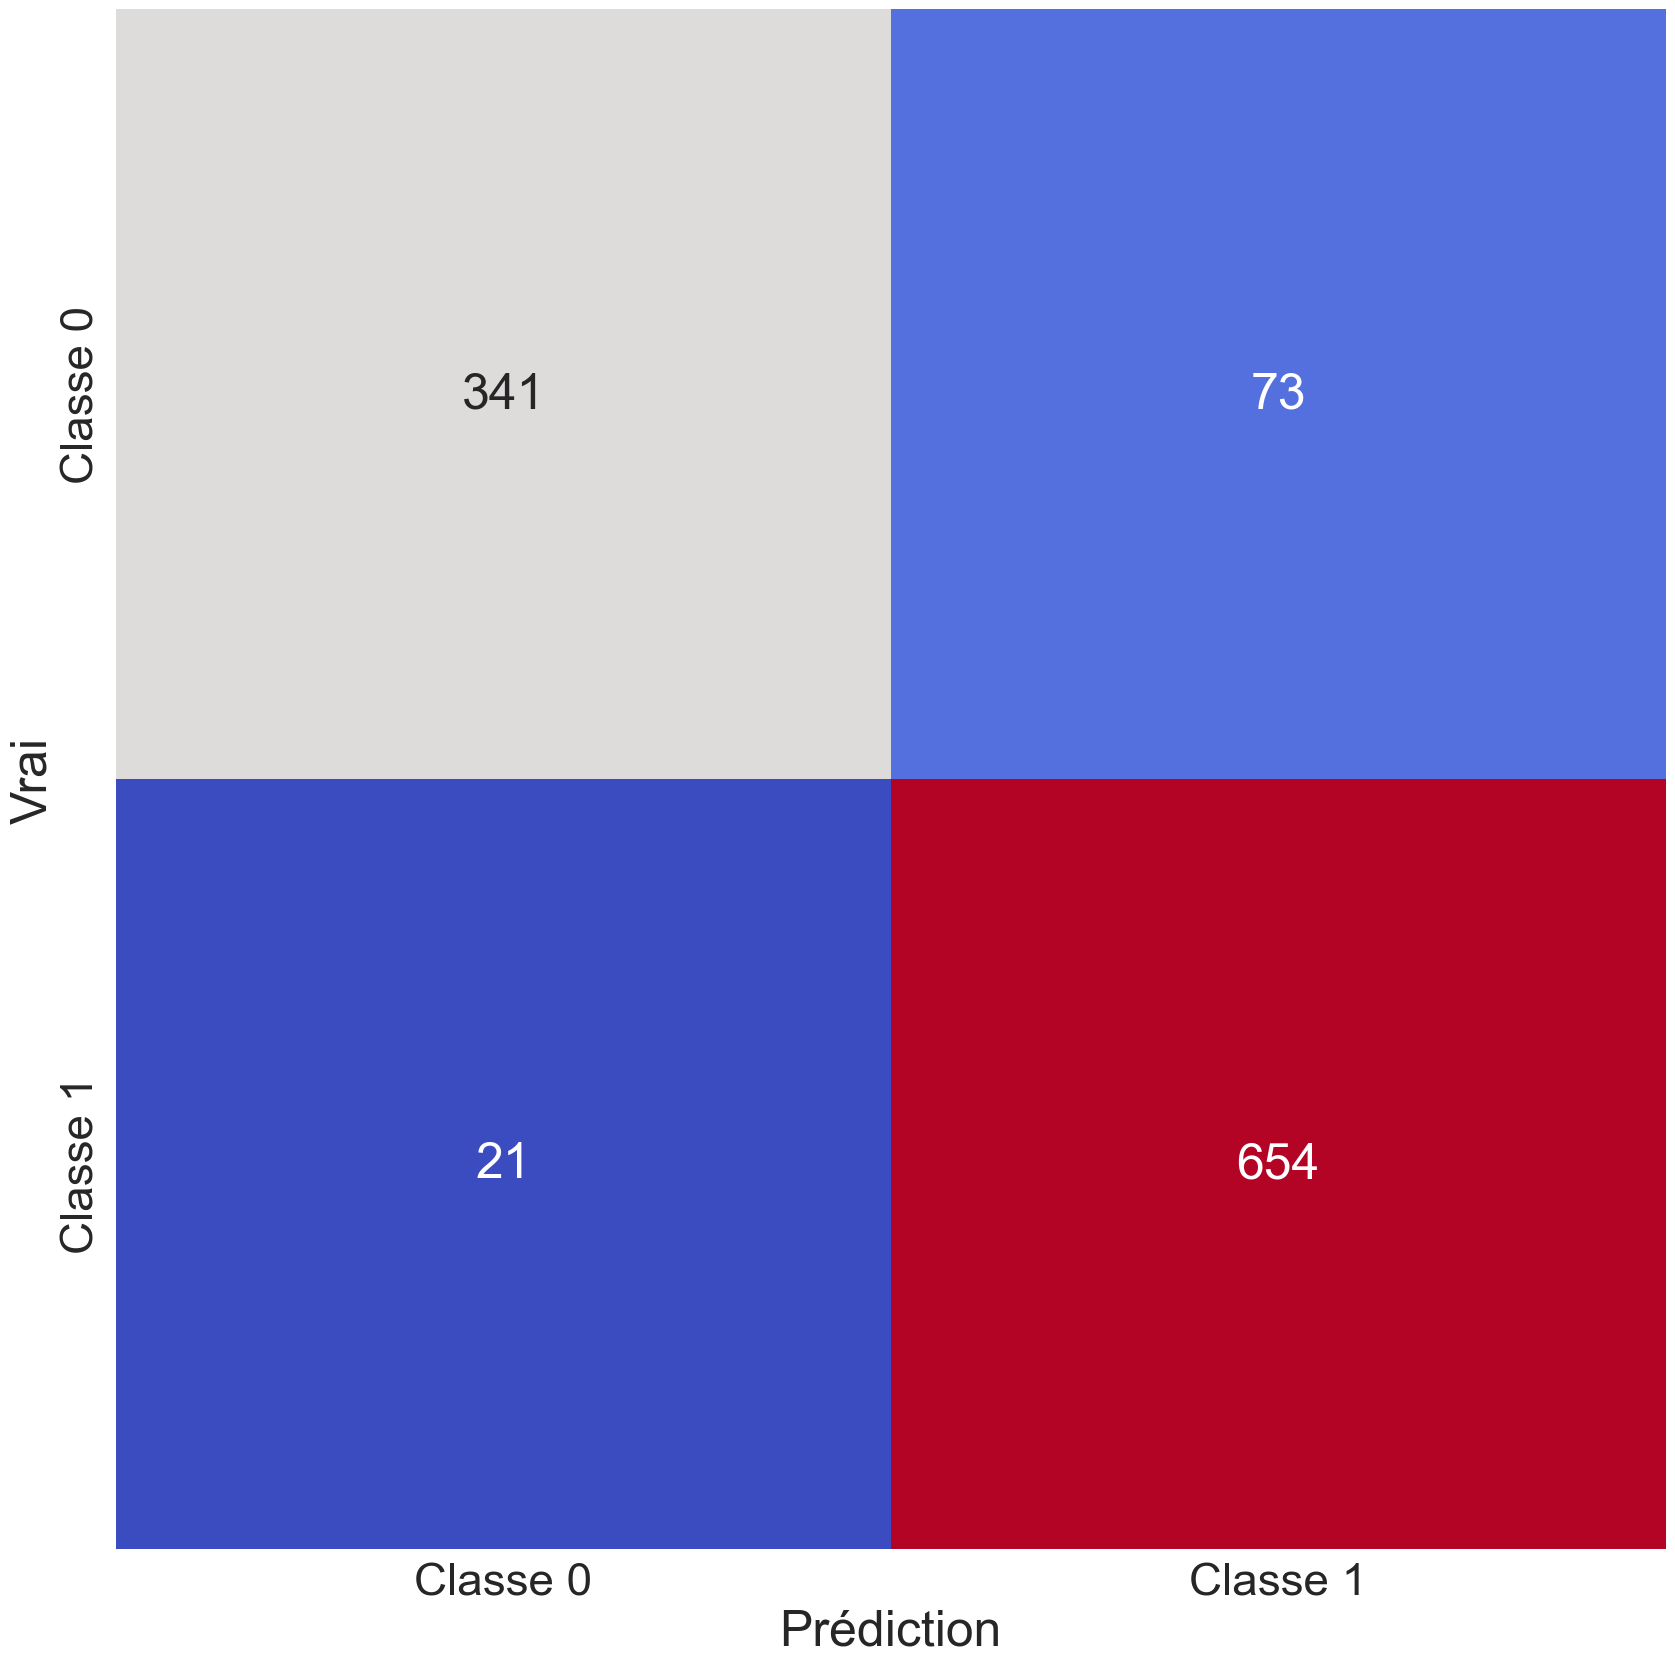

In [7]:
utils.conf_matrix(y_test, catboost_clf.predict(X_test))

## Section pour l'analyse avec les valeurs SHAP

### `Explication de comment SHAP fonctionne`

À Écrire...

### Initialisation de SHAP

In [8]:
shap.initjs()

### Calcul des valeurs SHAP

In [9]:
explainer = shap.TreeExplainer(catboost_clf)
shap_values = explainer(X_train)

### Feature importance pour les valeurs SHAP

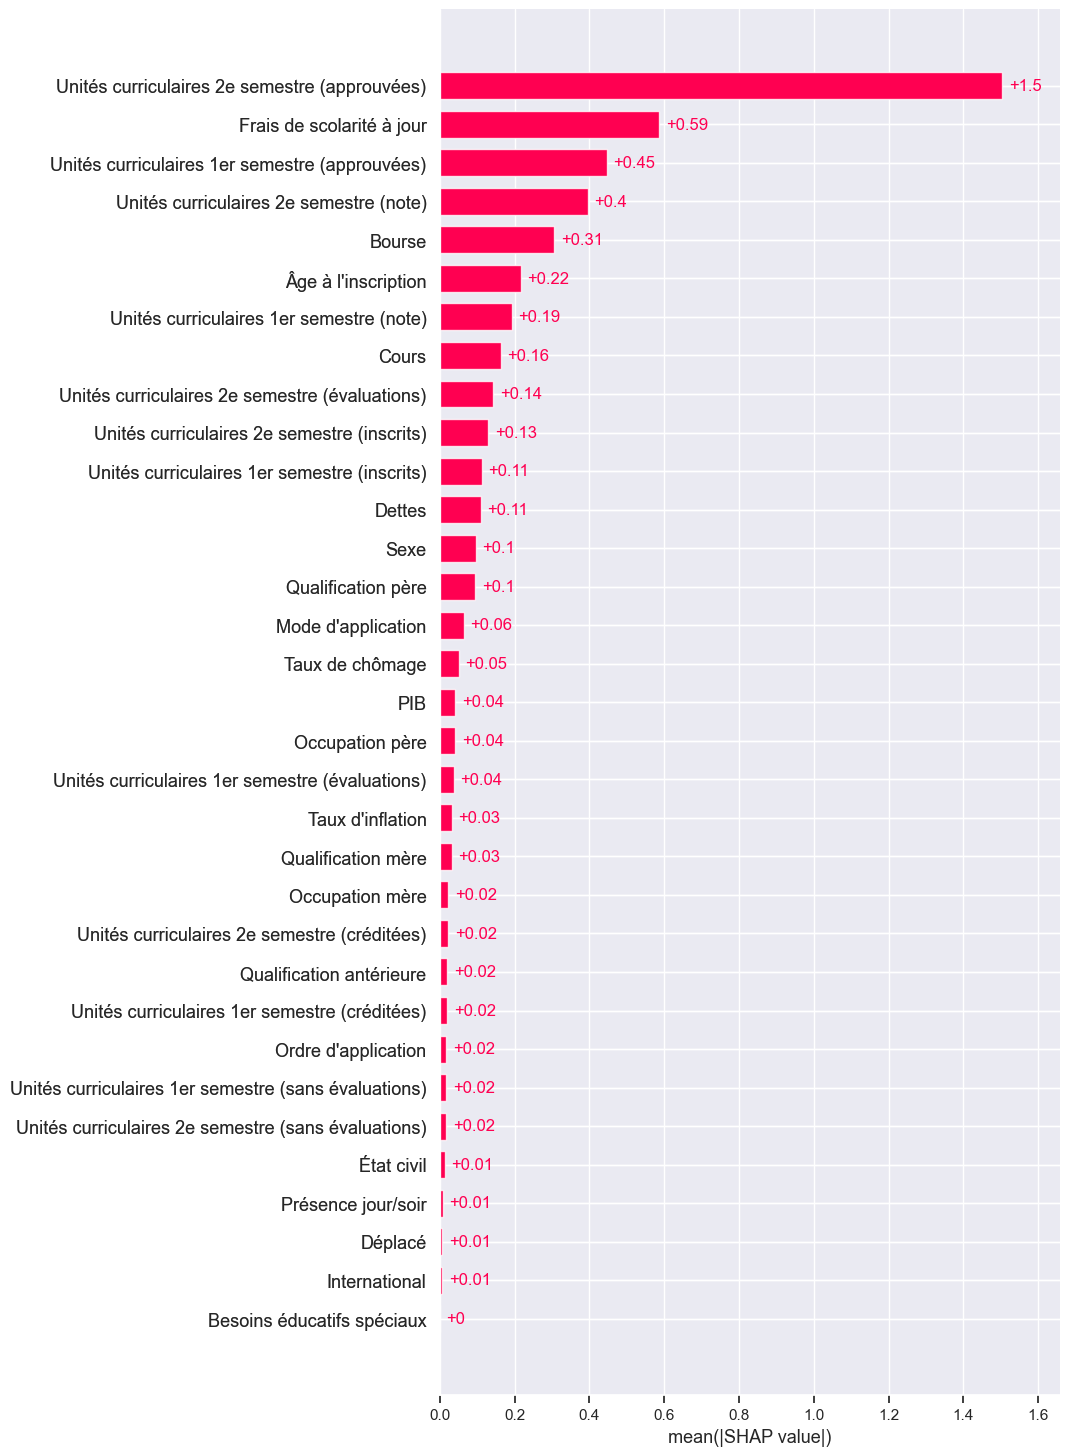

In [10]:
#Mean SHAP
shap.plots.bar(shap_values, max_display=35)

### Beeswarm des valeurs SHAP

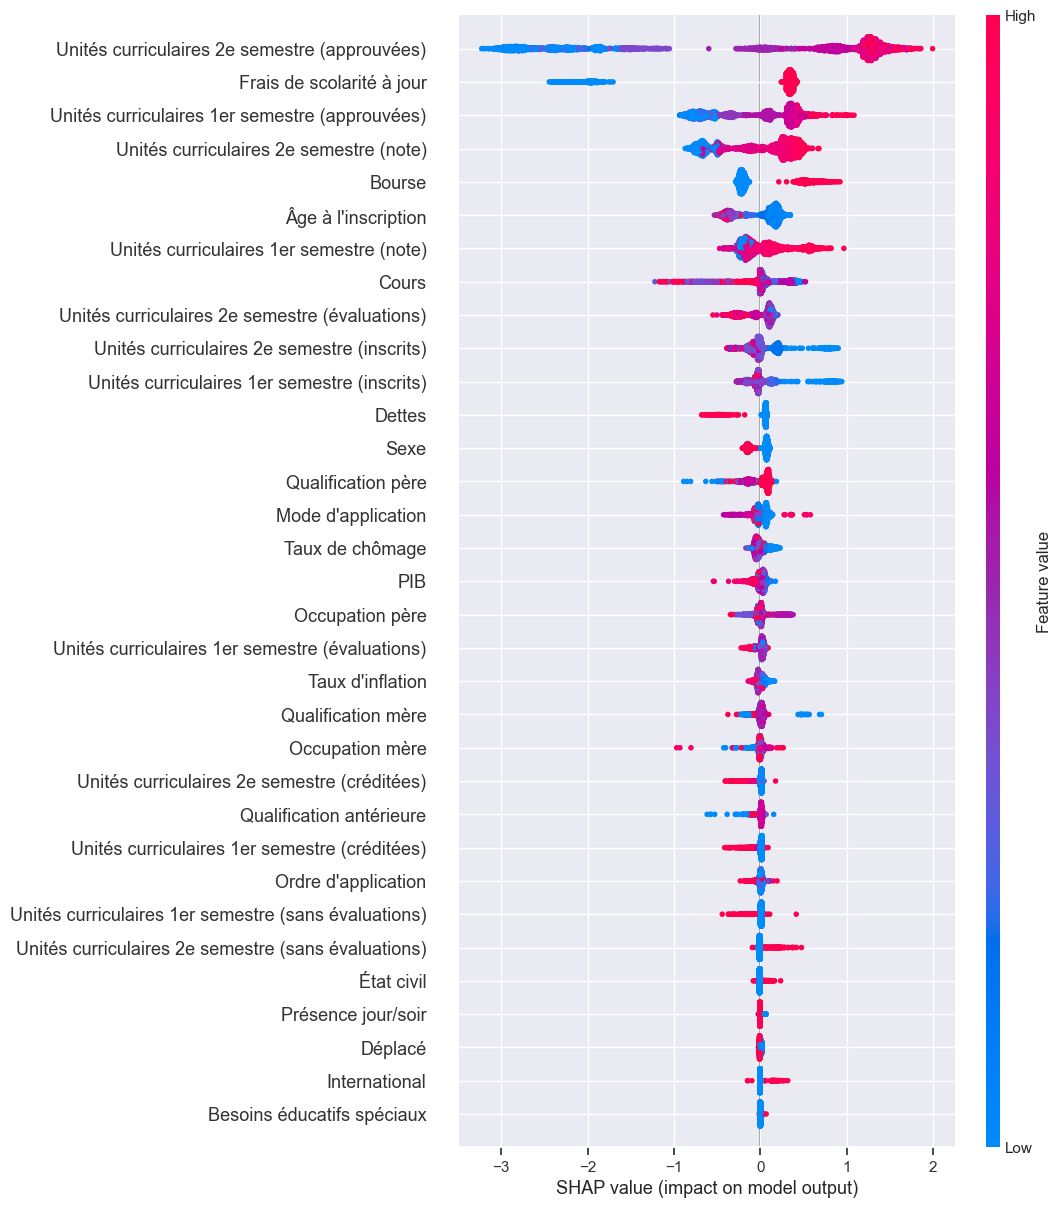

In [11]:
# Beeswarm plot
shap.plots.beeswarm(shap_values, max_display=35)

### Exemple sur un échantillon des données pour voir l'impact des features sur la prédiction

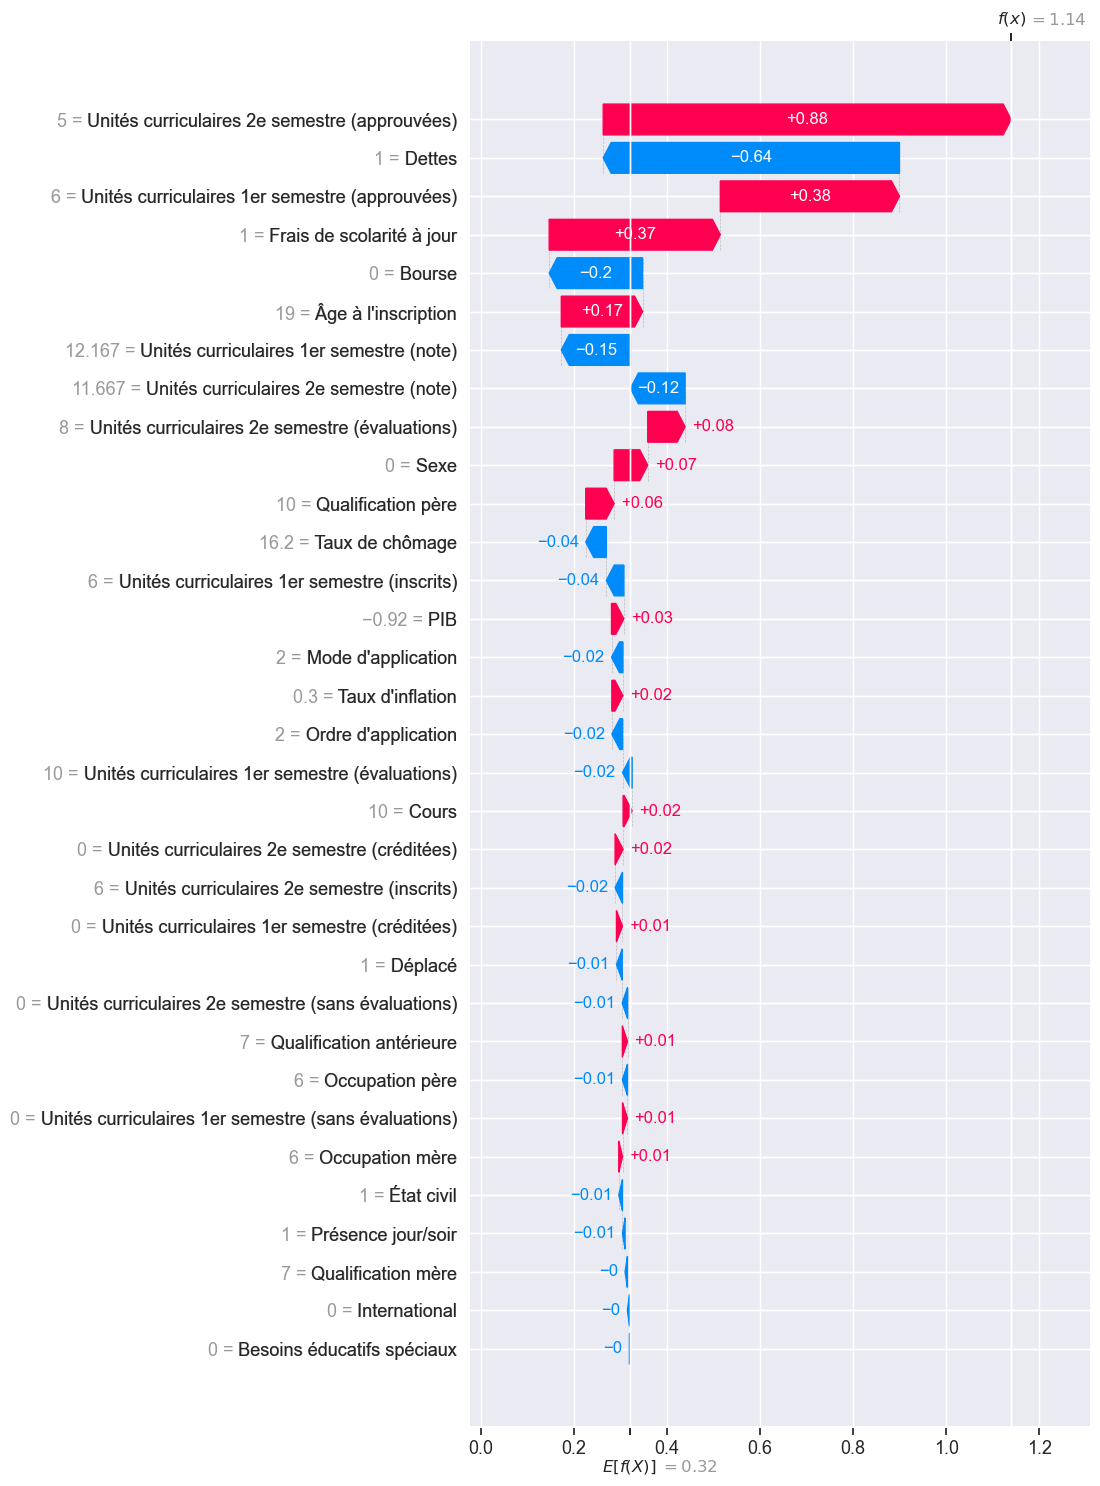

In [12]:
shap.waterfall_plot(shap_values[100], max_display=34)

### Force plot des valeurs SHAP

In [13]:
#shap.plots.force(shap_values)

# Hypothèses et discussion des résultats obtenus avec les valeurs SHAP

## Données académiques à l'inscription

### `Mode d'application`

- C'est un feature catégorique non-binaire donc, c'est difficile d'interprété le beeswarm. Par contre on peut analyser plus en profondeur. 
- Le feature n'est pas le plus important, mais pas le moins important non plus.
- La majorité des étudiants de notre jeu de données ont appliqué en `1ère phase`.
- Sa valeur moyenne absolue SHAP est de `0.06` ce qui est pas beaucoup.
- Le mode d'application `Étudiant international (baccalauréat)` a un impact positif en moyenne (`0.3737`) assez important sur les prédictions du modèle.
- Le mode d'application `Transfert` a un impact négatif en moyenne (`-0.303947`) assez important sur les prédictions du modèle.

Les modes d'application `Étudiant international (baccalauréat)` et `Transfert` ont quand même beaucoup d'impact sur les prédictions du modèle, les modes d'application restant ont beaucoup moins d'impact. Reste que le `Mode d'application` ne fait pas parti des features les plus importants.

In [14]:
utils.get_mean_impact_shap_category(shap_values, X_train, "Mode d'application")

Moyenne des valeurs SHAP pour chaque catégories du feature : Mode d'application
---------------------------------------------------------------------------


,Valeur SHAP moyenne,Nom catégorie
10.0,0.373734,Étudiant international (baccalauréat)
1.0,0.074879,1ère phase
5.0,-0.015984,Diplôme spécialisation/technologique
6.0,-0.018259,Diplôme cycle court
2.0,-0.021618,2e phase
3.0,-0.048223,3e phase
11.0,-0.051991,Plus de 23 ans
9.0,-0.055545,Ordonnance
4.0,-0.057450,"Titulaire diplôme (bacc, maîtrise, doc)"
8.0,-0.104809,Changement d'établissement/cours


### `Ordre d'application`

- C'est un feature qui a pas beaucoup d'impact sur les prédictions du modèle.
- Sa valeur moyenne absolue SHAP est de `0.02` ce qui est pas beaucoup.
- La majorité des étudiants ont `1` comme `ordre d'application`.

Il est possible de faire l'hypothèse que `l'ordre d'application` d'un étudiant n'est pas un facteur significatif.

### `Cours`

- C'est un feature catégorique non-binaire donc, c'est difficile d'interprété le beeswarm. Par contre on peut analyser plus en profondeur. 
- Sa valeur moyenne absolue SHAP est de `0.16` ce qui est quand même beaucoup.
- C'est dûr de tirer des conclusions générales sur les cours, car il n'y a pas tout les cours, et la prédiction des étudiants selon les cours peuvent être expliqué par de multiples facteurs.
- En tenant compte de ce jeu de données, les cours comme `Génie informatique`, `Éducation de base` et `Équiniculture` sont des cours qui ont des impacts négatifs en moyenne (`-0.743481`, `-0.720484` et `-0.479812`) assez importants sur les prédictions du modèle.
- Aussi, les cours comme `Conception d'animation et multimédia` et `Service social` sont des cours qui ont des impacts positifs en moyenne (`0.372233` et `0.330540`) assez important sur les prédictions du modèle.

On ne peut pas généraliser l'impact des cours spécifique sur les prédictions du modèle, car on on a pas accès à tout les cours etc.. mais on peut constater que le `cours` choisi par un étudiant peut être un facteur prédictif du modèle.

In [15]:
utils.get_mean_impact_shap_category(shap_values, X_train, "Cours")

Moyenne des valeurs SHAP pour chaque catégories du feature : Cours
---------------------------------------------------------------------------


,Valeur SHAP moyenne,Nom catégorie
2.0,0.372233,Conception d'animation et multimédia
9.0,0.330540,Service social
5.0,0.122452,Soins infirmiers vétérinaires
10.0,0.055218,Tourisme
4.0,0.032949,Conception de communications
8.0,0.031732,Gestion
3.0,0.009910,Agronomie
13.0,0.002409,Gestion de la publicité et du marketing
12.0,0.001653,Hygiène buccale (Dentiste ou Hygiéniste dentaire)
1.0,-0.000447,Technologies de production de biocarburants


### `Présence jour/soir`

- C'est un feature qui a pas beaucoup d'impact sur les prédictions du modèle.
- Sa valeur moyenne absolue SHAP est de `0.01` ce qui est pas beaucoup.

Il est possible de faire l'hypothèse que `Présence jour/soir` n'est pas un facteur prédictif significatif. Qu'un étudiant prend des cours le jour ou le soir n'influencera pas significativement le fait qu'il va gradué ou abandonner l'université.

In [16]:
utils.get_mean_impact_shap_category(shap_values, X_train, "Présence jour/soir")

Moyenne des valeurs SHAP pour chaque catégories du feature : Présence jour/soir
---------------------------------------------------------------------------


,Valeur SHAP moyenne,Nom catégorie
0.0,0.037087,Soir
1.0,-0.004539,Jour


### `Qualification antérieure`

- C'est un feature catégorique non-binaire donc, c'est difficile d'interprété le beeswarm. Par contre on peut analyser plus en profondeur. 
- C'est un feature qui a pas beaucoup d'impact sur les prédictions du modèle.
- Sa valeur moyenne absolue SHAP est de `0.02` ce qui est pas beaucoup.
- La qualification antérieure `Étude supérieure – baccalauréat` a un impact négatif en moyenne (`-0.306467`) assez important sur les prédictions du modèle.

Il est possible de faire l'hypothèse que la `Qualification antérieure` n'est pas un facteur prédictif significatif à une exception près. On constate que lorsqu'un étudiant détient un baccalauréat à un impact négatif sur les prédictions du modèle.


In [17]:
utils.get_mean_impact_shap_category(shap_values, X_train, "Qualification antérieure")

Moyenne des valeurs SHAP pour chaque catégories du feature : Qualification antérieure
---------------------------------------------------------------------------


,Valeur SHAP moyenne,Nom catégorie
7.0,0.010907,Étude secondaire – 12e année de scolarité ou é...
6.0,0.008322,Cours spécialisation/technique
2.0,-0.049558,Étude supérieure – maîtrise
5.0,-0.052371,Fréquence d'étude supérieure
8.0,-0.074282,Éducation de base
4.0,-0.085154,Étude supérieure – diplôme
3.0,-0.306467,Étude supérieure – baccalauréat


## Données académiques au 1er semestre

### `Unités curriculaires 1er semestre (inscrits)`

- Sa valeur moyenne absolue SHAP est de `0.11` ce qui est peut être important.
- Un nombre d'`unités curriculaires (inscrit)` faible au `1er semestre` a un impact positif sur les prédictions du modèle.
- Un nombre d'`unités curriculaires (inscrit)` élevé au `1er semestre` a un impact négatif sur les prédictions du modèle.

### `Unités curriculaires 1er semestre (créditées)`

- Sa valeur moyenne absolue SHAP est de `0.02` ce qui est pas beaucoup.


### `Unités curriculaires 1er semestre (évaluations)`

- Sa valeur moyenne absolue SHAP est de `0.04` ce qui est pas beaucoup.
- Le nombre d'unités curriculaires en terme d'évaluation au 1er semestre n'a pas autant d'impact qu'au 2e semestre.

### `Unités curriculaires 1er semestre (sans évaluations)`

- Sa valeur moyenne absolue SHAP est de `0.02` ce qui est pas beaucoup.

### `Unités curriculaires 1er semestre (approuvées)`

- Sa valeur moyenne absolue SHAP est de `0.45` ce qui est vraiment beaucoup et important.
- Un nombre d'`unités curriculaires (approuvées)` faible au `1er semestre` a un impact négatif important sur les prédictions du modèle.
- Un nombre d'`unités curriculaires (approuvées)` élevé au `1er semestre` a un impact positif important sur les prédictions du modèle.
- Le nombre d'`unités curriculaires (approuvées)` au `1er semestre` a moins d'impact qu'au `2e semestre`.

### `Unités curriculaires 1er semestre (note)`

- Sa valeur moyenne absolue SHAP est de `0.19` ce qui est quand même beaucoup.
- Un nombre d'`unités curriculaires (note)` faible au `1er semestre` a un impact négatif sur les prédictions du modèle.
- Un nombre d'`unités curriculaires (note)` élevé au `1er semestre` a un impact postif sur les prédictions du modèle.
- Le nombre d'`unités curriculaires (note)` au `1er semestre` a moins d'impact qu'au `2e semestre`.

## Données académiques au 2e semestre

### `Unités curriculaires 2e semestre (inscrits)`

- Sa valeur moyenne absolue SHAP est de `0.13` ce qui peut être important.
- Un nombre d'`unités curriculaires (inscrit)` faible au `2e semestre` a un impact positif sur les prédictions du modèle.
- Un nombre d'`unités curriculaires (inscrit)` élevé au `2e semestre` a un impact négatif sur les prédictions du modèle.

### `Unités curriculaires 2e semestre (créditées)`

- Sa valeur moyenne absolue SHAP est de `0.02` ce qui est pas beaucoup.

### `Unités curriculaires 2e semestre (évaluations)`

- Sa valeur moyenne absolue SHAP est de `0.14` ce qui peut être important.
- Un nombre d'`unités curriculaires (évaluations)` faible au `2e semestre` a un impact positif sur les prédictions du modèle.
- Un nombre d'`unités curriculaires (évaluations)` élevé au `2e semestre` a un impact négatif sur les prédictions du modèle.

### `Unités curriculaires 2e semestre (sans évaluations)`

- Sa valeur moyenne absolue SHAP est de `0.02` ce qui est pas beaucoup.

### `Unités curriculaires 2e semestre (approuvées)`

- C'est le features le plus important selon le bar plot SHAP et selon feature_importance du modèle CatBoost.
- Sa valeur moyenne absolue SHAP est de `1.50` ce qui est vraiment beaucoup.
- Un nombre faible d'`unités curriculaire` au `2e semestre (approuvées)` a un impact négatif sur les prédictions du modèle, c'est-à-dire qu'il pousse plus la prédiction vers l'abandon.
- Un nombre élevé d'`unités curriculaire` au `2e semestre (approuvées)` a un impact positif sur les prédictions du modèle, c'est-à-dire qu'il pousse plus la prédiction vers la graduation.

### `Unités curriculaires 2e semestre (note)`

- Sa valeur moyenne absolue SHAP est de `0.40` ce qui est vraiment beaucoup.
- Un nombre d'`unités curriculaires (note)` faible au `2e semestre` a un impact négatif sur les prédictions du modèle.
- Un nombre d'`unités curriculaires (note)` élevé au `2e semestre` a un impact postif sur les prédictions du modèle.

## Données macroéconomiques

### `PIB (À l'inscription de l'étudiant)` 

- Sa valeur moyenne absolue SHAP est de `0.04` ce qui est pas beaucoup.
- Plusieurs facteurs pourrait expliquer la relation complexe entre le PIB et les prédictions du modèle, mais ce n'est pas un facteur prédictif assez important pour l'analyser plus en profondeur.

### `Taux de chômage (À l'inscription de l'étudiant)`

- Sa valeur moyenne absolue SHAP est de `0.05` ce qui est pas beaucoup.
- Plus le `Taux de chômage` est élevé, plus l'impact est négatif sur les prédictions du modèle. L'inverse est aussi vrai.

### `Taux d'inflation (À l'inscription de l'étudiant)`

- Sa valeur moyenne absolue SHAP est de `0.03` ce qui est pas beaucoup.
- Plus le `Taux d'inflation` est élevé, plus l'impact est négatif sur les prédictions du modèle. L'inverse est aussi vrai.

## Données socioéconomiques

### `Qualification père`

- Sa valeur moyenne absolue SHAP est de `0.10` ce qui peut être important.

- Les `Qualification du père` est dûr à interprété dans ce contexte

In [18]:
utils.get_mean_impact_shap_category(shap_values, X_train, "Qualification père")

Moyenne des valeurs SHAP pour chaque catégories du feature : Qualification père
---------------------------------------------------------------------------


,Valeur SHAP moyenne,Nom catégorie
10.0,0.072069,Éducation de base
2.0,-0.076803,Étude supérieure – maîtrise
9.0,-0.086238,Cours complémentaires
5.0,-0.087342,Fréquence d'étude supérieure
1.0,-0.098280,Étude supérieure – doctorat
4.0,-0.101554,Étude supérieure – diplôme
11.0,-0.112612,Aucune éducation
6.0,-0.132669,Cours spécialisation/technique
8.0,-0.134699,Étude secondaire
12.0,-0.172755,Inconnu


### `Occupation père`

- Sa valeur moyenne absolue SHAP est de `0.04` ce qui est pas beaucoup.

In [19]:
utils.get_mean_impact_shap_category(shap_values, X_train, "Occupation père")

Moyenne des valeurs SHAP pour chaque catégories du feature : Occupation père
---------------------------------------------------------------------------


,Valeur SHAP moyenne,Nom catégorie
7.0,0.265160,Agriculteurs et travailleurs qualifiés de l’ag...
18.0,0.150524,Personnel de soutien administratif
9.0,0.026167,"Opérateurs d'installations, de machines et ouv..."
17.0,0.018207,"Spécialistes en finance, comptabilité, organis..."
8.0,0.009096,"Ouvriers qualifiés de l’industrie, de la const..."
4.0,0.008523,Techniciens et professions de niveau intermédi...
14.0,0.004943,Directeurs des services administratifs et comm...
11.0,0.003675,Métiers des Forces armées
2.0,0.002632,Représentants du Pouvoir Législatif et des Org...
6.0,0.001714,"Travailleurs des services personnels, de la sé..."


### `Qualification mère`

- Sa valeur moyenne absolue SHAP est de `0.03` ce qui est pas beaucoup.

In [20]:
utils.get_mean_impact_shap_category(shap_values, X_train, "Qualification mère")

Moyenne des valeurs SHAP pour chaque catégories du feature : Qualification mère
---------------------------------------------------------------------------


,Valeur SHAP moyenne,Nom catégorie
2.0,0.518908,Étude supérieure – maîtrise
9.0,0.016548,Cours complémentaires
8.0,0.014709,Étude secondaire
7.0,0.010254,Cours administration/commerce
3.0,-0.007319,Étude supérieure – baccalauréat
5.0,-0.008533,Fréquence d'étude supérieure
6.0,-0.014893,Cours spécialisation/technique
12.0,-0.021557,Inconnu
1.0,-0.022294,Étude supérieure – doctorat
10.0,-0.079553,Éducation de base


### `Occupation mère`

- Sa valeur moyenne absolue SHAP est de `0.02` ce qui est pas beaucoup.

In [21]:
utils.get_mean_impact_shap_category(shap_values, X_train, "Occupation mère")

Moyenne des valeurs SHAP pour chaque catégories du feature : Occupation mère
---------------------------------------------------------------------------


,Valeur SHAP moyenne,Nom catégorie
17.0,0.229455,"Spécialistes en finance, comptabilité, organis..."
8.0,0.043369,"Ouvriers qualifiés de l’industrie, de la const..."
7.0,0.039324,Agriculteurs et travailleurs qualifiés de l’ag...
6.0,0.031363,"Travailleurs des services personnels, de la sé..."
11.0,0.008217,Métiers des Forces armées
5.0,0.008000,Personnel administratif
18.0,0.006576,Personnel de soutien administratif
15.0,0.002081,Professionnels de la santé
10.0,-0.002850,Travailleurs sans compétences
16.0,-0.005605,Enseignants


### `Besoins éducatifs spéciaux`

- Sa valeur moyenne absolue SHAP est de `0.0` ce qui est pratiquement nulle.

In [22]:
utils.get_mean_impact_shap_category(shap_values, X_train, "Besoins éducatifs spéciaux")

Moyenne des valeurs SHAP pour chaque catégories du feature : Besoins éducatifs spéciaux
---------------------------------------------------------------------------


,Valeur SHAP moyenne,Nom catégorie
1.0,0.019342,Oui
0.0,-0.000295,Non


### `Dettes`

- Sa valeur moyenne absolue SHAP est de `0.11` ce qui peut être important.
- Avoir des `Dettes` a un impact négatif sur les prédictions du modèle.

In [23]:
utils.get_mean_impact_shap_category(shap_values, X_train, "Dettes")

Moyenne des valeurs SHAP pour chaque catégories du feature : Dettes
---------------------------------------------------------------------------


,Valeur SHAP moyenne,Nom catégorie
0.0,0.060700,Non
1.0,-0.479535,Oui


### `Frais de scolarité à jour`

- Sa valeur moyenne absolue SHAP est de `0.59` ce qui est vraiment beaucoup et important.
- Avoir des `Frais de scolarité à jour` a vraiment un impact positif sur les prédictions du modèle.
- Ne pas avoir des `Frais de scolarité à jour` a vraiment un impact négatif sur les prédictions du modèle.

In [24]:
utils.get_mean_impact_shap_category(shap_values, X_train, "Frais de scolarité à jour")

Moyenne des valeurs SHAP pour chaque catégories du feature : Frais de scolarité à jour
---------------------------------------------------------------------------


,Valeur SHAP moyenne,Nom catégorie
1.0,0.345621,Oui
0.0,-2.047663,Non


### `Bourse`

- Sa valeur moyenne absolue SHAP est de `0.31` ce qui est vraiment beaucoup et important.
- Avoir une `Bourse` a vraiment un impact positif sur les prédictions du modèle.
- Ne pas avoir de `Bourse` a vraiment un impact négatif sur les prédictions du modèle.

In [25]:
utils.get_mean_impact_shap_category(shap_values, X_train, "Bourse")

Moyenne des valeurs SHAP pour chaque catégories du feature : Bourse
---------------------------------------------------------------------------


,Valeur SHAP moyenne,Nom catégorie
1.0,0.558776,Oui
0.0,-0.210881,Non


## Données démographiques

### `État civil`

- Sa valeur moyenne absolue SHAP est de `0.01` ce qui est vraiment pas beaucoup.

In [26]:
utils.get_mean_impact_shap_category(shap_values, X_train, "État civil")

Moyenne des valeurs SHAP pour chaque catégories du feature : État civil
---------------------------------------------------------------------------


,Valeur SHAP moyenne,Nom catégorie
4.0,0.097594,Divorcé(e)
5.0,0.093687,Union de fait
2.0,0.042480,Marié(e)
3.0,0.029575,Veuf
6.0,0.017409,Séparés légalement
1.0,-0.007072,Célibataire


### `Déplacé`

- Sa valeur moyenne absolue SHAP est de `0.01` ce qui est vraiment pas beaucoup.

In [27]:
utils.get_mean_impact_shap_category(shap_values, X_train, "Déplacé")

Moyenne des valeurs SHAP pour chaque catégories du feature : Déplacé
---------------------------------------------------------------------------


,Valeur SHAP moyenne,Nom catégorie
0.0,0.006361,Non
1.0,-0.004767,Oui


### `Sexe`

- Sa valeur moyenne absolue SHAP est de `0.10` ce qui peut être important.
- Être un `homme` a un impact négatif sur les prédictions du modèle possiblement par le fait que dans nos données, il y a plus de femme que d'homme qui gradue.

In [28]:
utils.get_mean_impact_shap_category(shap_values, X_train, "Sexe")

Moyenne des valeurs SHAP pour chaque catégories du feature : Sexe
---------------------------------------------------------------------------


,Valeur SHAP moyenne,Nom catégorie
0.0,0.073452,Femme
1.0,-0.141563,Homme


### `Âge à l'inscription`

- Sa valeur moyenne absolue SHAP est de `0.22` ce qui est vraiment beaucoup et important.
- Plus t'es jeune à l'inscription, plus l'impact est positif sur les prédictions du modèle.
- Plus t'es âgé à l'inscription, plus l'impact est négatif sur les prédictions du modèle.

- La majorité des étudiants âgés de `23 ans et plus` applique à l'inscription pour les `23 ans et plus`.

In [102]:
X.loc[(X["Âge à l\'inscription"] >= 23)]["Mode d'application"].value_counts()

11    664
8     164
4     126
1      69
7      42
5      39
2      35
3       7
9       6
6       5
10      4
Name: Mode d'application, dtype: int64

In [107]:
X.loc[(X["Âge à l\'inscription"] >= 23)]["Qualification antérieure"].value_counts()

7    710
8    212
4    147
6     52
3     22
2     12
5      5
1      1
Name: Qualification antérieure, dtype: int64

In [123]:
X_train.loc[(y_train == 0)]["Âge à l'inscription"].mean()

25.835153922542204

In [124]:
X_train.loc[(y_train == 1)]["Âge à l'inscription"].mean()

21.652542372881356

### `International`

- Sa valeur moyenne absolue SHAP est de `0.01` ce qui est pas beaucoup.

In [29]:
utils.get_mean_impact_shap_category(shap_values, X_train, "International")

Moyenne des valeurs SHAP pour chaque catégories du feature : International
---------------------------------------------------------------------------


,Valeur SHAP moyenne,Nom catégorie
1.0,0.150894,Oui
0.0,-0.003168,Non


# Analyse de l'influence des features sur les résultats scolaires

In [30]:
my_list = list(X_train.columns)
my_dict = {}
for index, element in enumerate(my_list):
    my_dict[element] = index

print(my_dict)

{'État civil': 0, "Mode d'application": 1, "Ordre d'application": 2, 'Cours': 3, 'Présence jour/soir': 4, 'Qualification antérieure': 5, 'Qualification mère': 6, 'Qualification père': 7, 'Occupation mère': 8, 'Occupation père': 9, 'Déplacé': 10, 'Besoins éducatifs spéciaux': 11, 'Dettes': 12, 'Frais de scolarité à jour': 13, 'Sexe': 14, 'Bourse': 15, "Âge à l'inscription": 16, 'International': 17, 'Unités curriculaires 1er semestre (créditées)': 18, 'Unités curriculaires 1er semestre (inscrits)': 19, 'Unités curriculaires 1er semestre (évaluations)': 20, 'Unités curriculaires 1er semestre (approuvées)': 21, 'Unités curriculaires 1er semestre (note)': 22, 'Unités curriculaires 1er semestre (sans évaluations)': 23, 'Unités curriculaires 2e semestre (créditées)': 24, 'Unités curriculaires 2e semestre (inscrits)': 25, 'Unités curriculaires 2e semestre (évaluations)': 26, 'Unités curriculaires 2e semestre (approuvées)': 27, 'Unités curriculaires 2e semestre (note)': 28, 'Unités curriculaire

In [31]:
def correlation_features(feature_name, features_dict, shap_values):
    feature_names = list(features_dict.keys())
    feature_correlation = []
    for name in feature_names:
        correlation_matrix = np.corrcoef(shap_values.values[:, features_dict[feature_name]], shap_values.values[:, features_dict[name]])
        correlation = correlation_matrix[0, 1]
        feature_correlation.append(correlation)
    feature_correlation = np.array(feature_correlation)

    print(f"Corrélation des valeurs SHAP du feature {feature_name} avec les autres features")
    print("---------------------------------------------------------------------------")

    df = pd.DataFrame(feature_correlation, index=list(features_dict.values()), columns=["Correlation SHAP"])
    df = pd.concat([df, pd.DataFrame(feature_names, index=list(features_dict.values()), columns=["Nom catégorie"])], axis=1)
    return df.sort_values(by='Correlation SHAP', ascending=False)

In [32]:
correlation_features("Unités curriculaires 2e semestre (approuvées)", my_dict, shap_values)

Corrélation des valeurs SHAP du feature Unités curriculaires 2e semestre (approuvées) avec les autres features
---------------------------------------------------------------------------


,Correlation SHAP,Nom catégorie
27,1.000000,Unités curriculaires 2e semestre (approuvées)
21,0.824060,Unités curriculaires 1er semestre (approuvées)
28,0.781935,Unités curriculaires 2e semestre (note)
22,0.467170,Unités curriculaires 1er semestre (note)
13,0.271288,Frais de scolarité à jour
14,0.258326,Sexe
15,0.236292,Bourse
16,0.235825,Âge à l'inscription
20,0.225285,Unités curriculaires 1er semestre (évaluations)
1,0.161344,Mode d'application


In [87]:
correlation_features("Unités curriculaires 2e semestre (note)", my_dict, shap_values)

Corrélation des valeurs SHAP du feature Unités curriculaires 2e semestre (note) avec les autres features
---------------------------------------------------------------------------


,Correlation SHAP,Nom catégorie
28,1.000000,Unités curriculaires 2e semestre (note)
27,0.781935,Unités curriculaires 2e semestre (approuvées)
21,0.707379,Unités curriculaires 1er semestre (approuvées)
22,0.586958,Unités curriculaires 1er semestre (note)
13,0.281402,Frais de scolarité à jour
20,0.225725,Unités curriculaires 1er semestre (évaluations)
16,0.214991,Âge à l'inscription
15,0.201950,Bourse
14,0.195299,Sexe
1,0.162757,Mode d'application


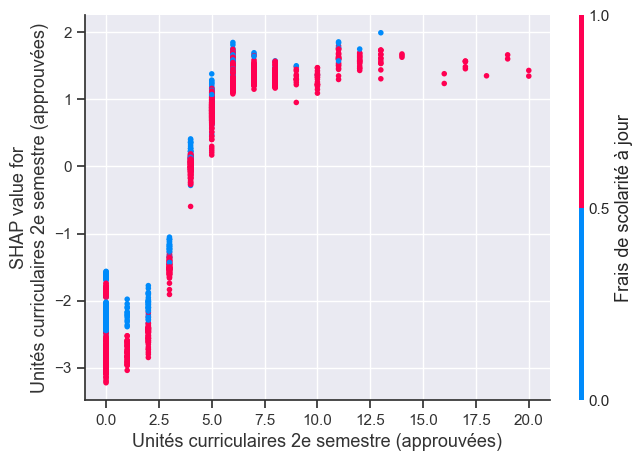

In [33]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("Unités curriculaires 2e semestre (approuvées)", shap_values.values, X_train, interaction_index="Frais de scolarité à jour")

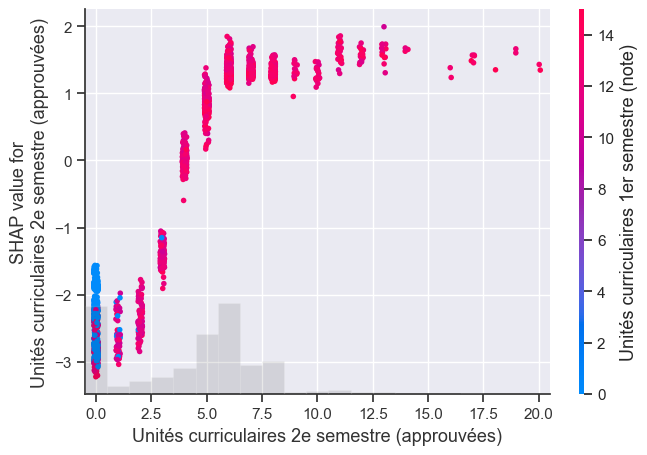

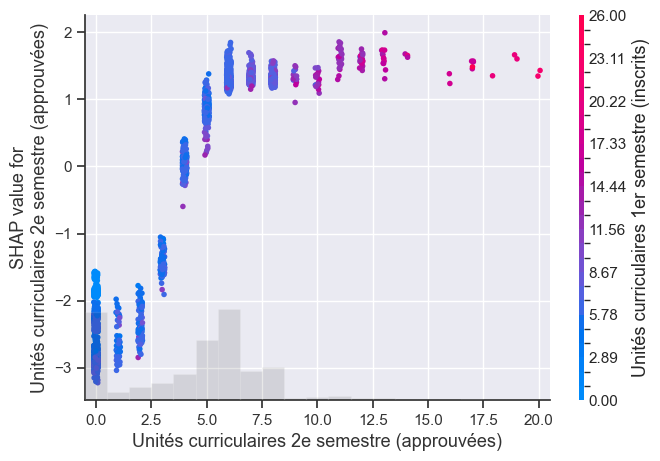

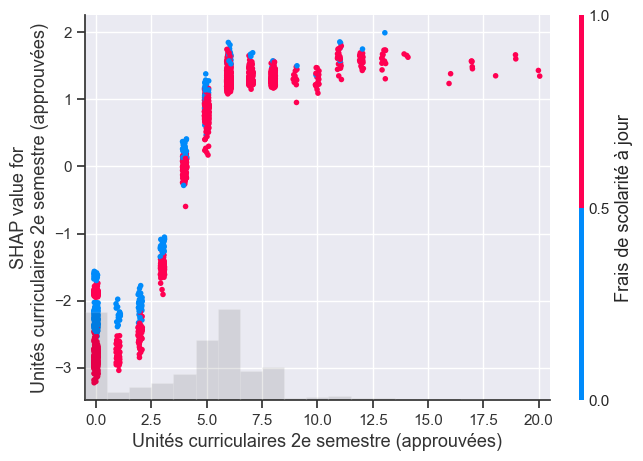

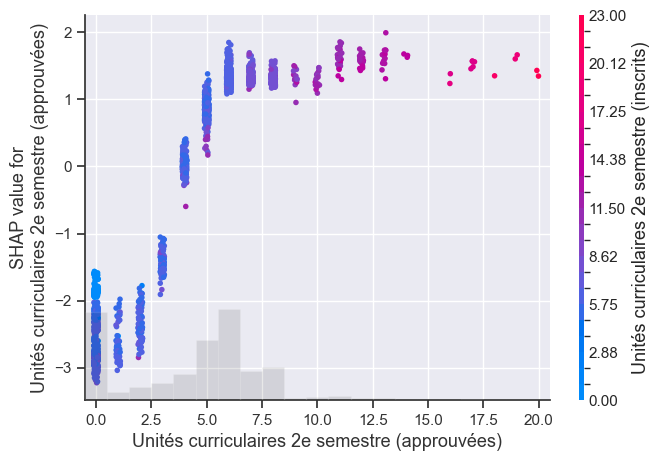

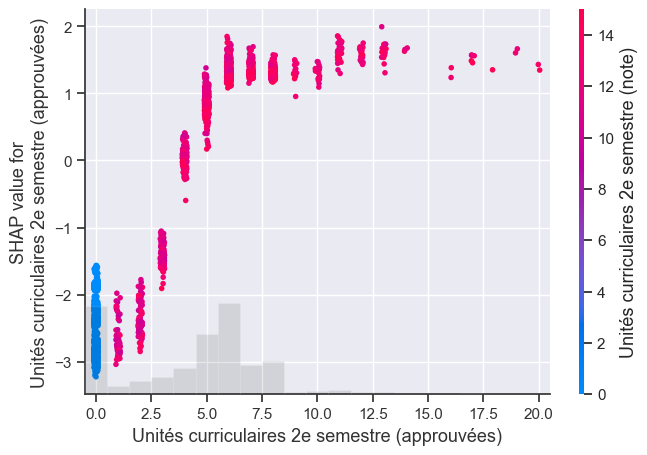

In [34]:
inds = shap.utils.potential_interactions(shap_values[:, my_dict["Unités curriculaires 2e semestre (approuvées)"]], shap_values)

# make plots colored by each of the top three possible interacting features
for i in range(5):
    shap.plots.scatter(shap_values[:, my_dict["Unités curriculaires 2e semestre (approuvées)"]], color=shap_values[:, inds[i]])

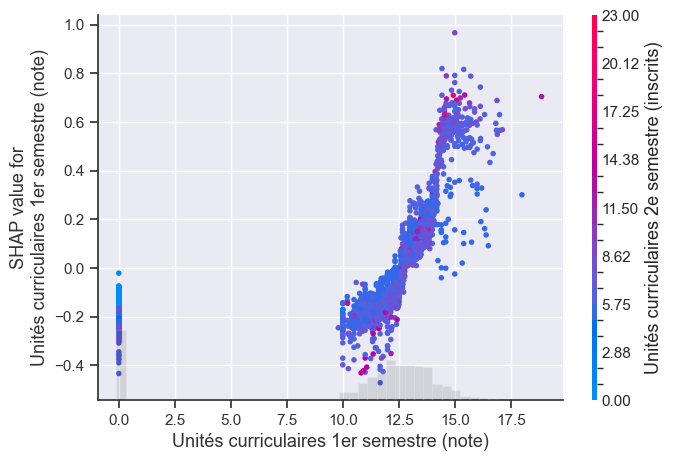

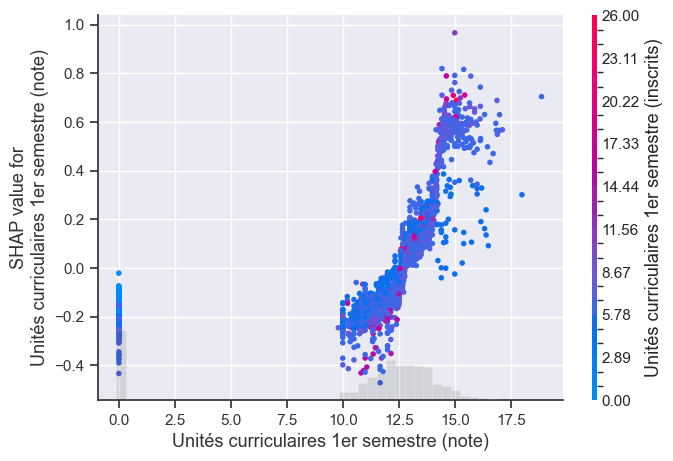

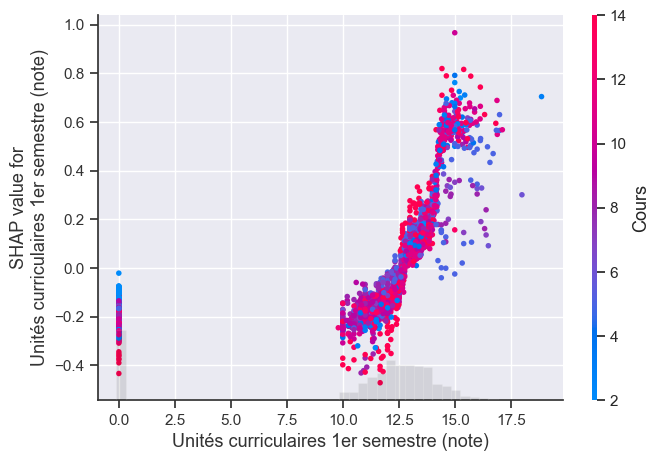

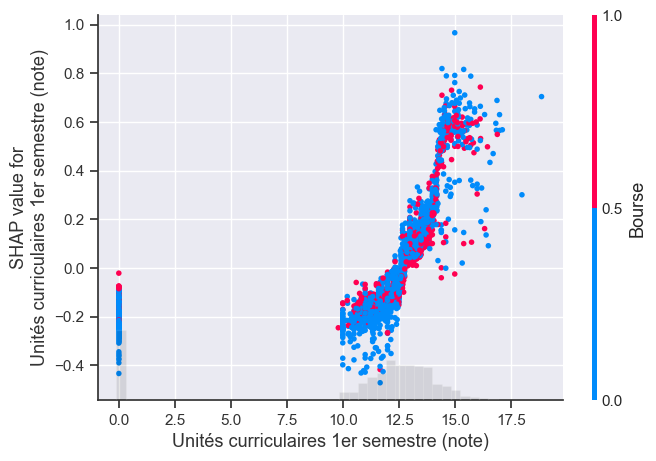

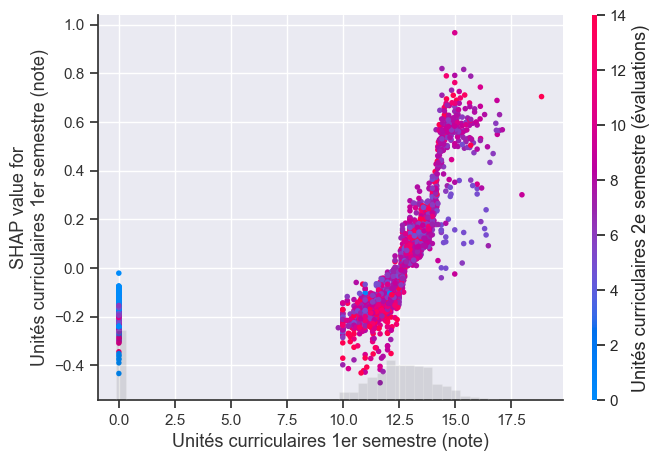

In [35]:
inds = shap.utils.potential_interactions(shap_values[:, my_dict["Unités curriculaires 1er semestre (note)"]], shap_values)

# make plots colored by each of the top three possible interacting features
for i in range(5):
    shap.plots.scatter(shap_values[:, my_dict["Unités curriculaires 1er semestre (note)"]], color=shap_values[:, inds[i]])